# Player + Number detector

In [1]:
! pip install gluoncv=='0.6.0'

     |████████████████████████████████| 693 kB 21.2 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


### Set up player detector

In [2]:
import datetime
import json
import math
import os
import shutil
import subprocess as sb
import tarfile

import boto3
import gluoncv
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon, nd
from mxnet import image as mximg

# import SageMaker tools
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet.model import MXNetModel

model_name = 'yolo3_darknet53_coco'
net = model_zoo.get_model(model_name, pretrained=True)

# in this demo we reset the detector to the "person" class

classes = ['person']

net.reset_class(classes=classes, reuse_weights=classes)
print('new classes: ', net.classes)

100%|██████████| 224190/224190 [00:06<00:00, 33414.61KB/s]


new classes:  ['person']


In [3]:
net.hybridize()  # hybridize to optimize computation

### Set up Number Detector

In [4]:
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
import time
from time import gmtime, strftime
import json

# TrainingJobName =no_od_model._current_job_name
TrainingJobName ="object-detection-2021-09-10-09-20-37-275"

final_no_model = sagemaker.estimator.Estimator.attach(TrainingJobName)


2021-09-10 09:27:29 Starting - Preparing the instances for training
2021-09-10 09:27:29 Downloading - Downloading input data
2021-09-10 09:27:29 Training - Training image download completed. Training in progress.
2021-09-10 09:27:29 Uploading - Uploading generated training model
2021-09-10 09:27:29 Completed - Training job completed


In [5]:
final_no_detector = final_no_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

--------------!

### Detector functions

In [6]:
def create_folders(folder):
    
    if not os.path.exists(folder):
        os.mkdir(folder)
    print("created folder {}".format(folder))

    output_dir = "{}/detected_frames".format(folder)
    temp_dir = "{}/temp".format(folder)

    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    print("created detection output directory {}".format(output_dir))

    if not os.path.exists(temp_dir):
        os.mkdir(temp_dir)
    print("created temperory player image directory {}".format(temp_dir))
    
    return temp_dir, output_dir

In [7]:
def extract_frames(folder,videoFile, seconds, ):
    # First, import some packages

    import cv2
    import math
    import numpy as np
    import os
    
    frames_folder = "{}/extracted_frames".format(folder)
    if not os.path.exists(frames_folder):
        os.mkdir(frames_folder)
    print("created detection output directory {}".format(frames_folder))

    # Capture every n seconds

    #################### Setting up the file ################
    vidcap = cv2.VideoCapture("{}/{}".format(folder,videoFile))
    success, image = vidcap.read()

    #################### Setting up parameters ################

    fps = int(math.ceil(vidcap.get(cv2.CAP_PROP_FPS))) # Gets the frames per second
    multiplier = int(math.ceil(fps * seconds))

    ################### Initiate Process ################
    # print(multiplier)
    count = 0
    
    while success:
        frameId = int(round(vidcap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
        success, image = vidcap.read()
    #     print(frameId)
        if frameId % multiplier == 0:
            count = count+1
            cv2.imwrite("{}/extracted_frames/frame{:06d}.jpg".format(folder,count),image)

    print("Extracted {} frames".format(count))
    vidcap.release()
    print("Complete")
    
    return frames_folder


In [8]:
def save_temp_crop(bbox, img, folder):
    
    # read bbox
    x0,y0,x1,y1 = bbox
    h = y1-y0
    w = x1-x0
    cropped = img[y0:y0+h , x0:x0+w, :]

    try:
        # save cropped imag
        img = plt.imshow(cropped, interpolation='nearest')
        img.set_cmap('hot')
        plt.axis('off')
        #save
        temp_file = "{}/temp.jpg".format(folder)
        
        if os.path.isfile(temp_file):
            os.remove(temp_file)   # Opt.: os.system("rm "+strFile)
            
        plt.savefig(os.path.join(folder,"temp.jpg"), bbox_inches='tight')
        plt.close()                    
    except ValueError:  #raised if `y` is empty.
        pass

In [9]:
def get_no_detection(folder, dets, classes=[], thresh=0.6,):
    
    import matplotlib.image as mpimg
    import random
    
    temp_no_list = []
    temp_x_list = []
    sorted_no_list = []
    n_bbox_list = []
    final_score = 0
    colors = dict()

    for det in dets:
        (klass, score, x0, y0, x1, y1) = det
        if score < thresh:
            continue
            
        n_xmin = x0
        n_ymin = y0
        n_xmax = x1
        n_ymax = y1
        
        # saving every number detected into the list
        temp_no_list.append(int(klass))
        temp_x_list.append(x0)
        n_bbox_list.append([n_xmin,n_ymin,n_xmax,n_ymax])
        final_score += score
    
    # arrange number list incresingly by x0, in the image, numbers are left to right
    zipped_no_lists = zip(temp_x_list, temp_no_list)
    sorted_zipped_no_lists = sorted(zipped_no_lists)
    sorted_no_list = [element for _, element in sorted_zipped_no_lists]                    
    no_str = ''.join(map(str, sorted_no_list))
    
    # arrange number bbox list incresingly by x0, in the image, numbers are left to right
    zipped_box_lists = zip(temp_x_list, n_bbox_list)
    sorted_zipped_box_lists = sorted(zipped_box_lists)
    sorted_no_list = [element for _, element in sorted_zipped_box_lists] 
    
    if (len(no_str) == 0):
        av_score = ""
    else:
        av_score = str(final_score/(len(no_str)))
    
    return no_str,av_score,sorted_no_list

In [10]:
def visualize_detection(img_file, bboxes, n_bboxes, no_lst, score_lst,save_folder,i):

        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        
        im_array =  mximg.imread(os.path.join(img_file))
        x, orig_img = data.transforms.presets.yolo.transform_test(im_array)

        plt.imshow(orig_img)
        
        colors = dict()
        
        # draw each player in frame
        for i in range(len(bboxes)):
            colors = (random.random(), random.random(), random.random())
            xmin = bboxes[i][0]
            ymin = bboxes[i][1]
            xmax = bboxes[i][2]
            ymax = bboxes[i][3]
            
            # height,width of player
            p_height = ymax - ymin
            p_width = xmax - xmin
            
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors,
                                 linewidth=1)
            plt.gca().add_patch(rect)
            
            if not no_lst[i]:
                plt.gca().text(xmin, ymin - 2,
                                'no number detected',
                                bbox=dict(facecolor=colors, alpha=0.5),
                                        fontsize=8, color='white')
            
            else:
                plt.gca().text(xmin, ymin - 2,
                                'no:{} score:{}'.format(no_lst[i], score_lst[i][:4]),
                                bbox=dict(facecolor=colors, alpha=0.5),
                                        fontsize=8, color='white')
            
            # draw each digit in player
            for j in range(len(n_bboxes[i])):

                n_xmin = int(n_bboxes[i][j][0] * p_width)
                n_ymin = int(n_bboxes[i][j][1] * p_height)
                n_xmax = int(n_bboxes[i][j][2] * p_width)
                n_ymax = int(n_bboxes[i][j][3] * p_height)
                
                n_rect = plt.Rectangle((n_xmin + xmin, n_ymin + ymin), n_xmax - n_xmin,
                                     n_ymax - n_ymin, fill=False,
                                     edgecolor=colors,
                                     linewidth=1)
                plt.gca().add_patch(n_rect)
                
                print("digit {} : {}".format(i,no_lst[i][j]))
                
                plt.gca().text(n_xmin + xmin, n_ymin + ymin - 2,
                                '{}'.format(no_lst[i][j]),
                                bbox=dict(facecolor=colors, alpha=0.5),
                                        fontsize=8, color='white')
                
                
        plt.show()

In [11]:
def clear_folder(folder):
    import os, shutil
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

### Apply player detector and number detector together

In [12]:
# set up folders
folder_name = "0910_Detector_Test_2"
vid = "epic_clip2.mp4"

created folder 0910_Detector_Test_2
created detection output directory 0910_Detector_Test_2/detected_frames
created temperory player image directory 0910_Detector_Test_2/temp
created detection output directory 0910_Detector_Test_2/extracted_frames
Extracted 19 frames
Complete
frame 0
[2021-09-15 06:38:16.296 ip-172-16-23-33:22724 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
digit 0 : 3


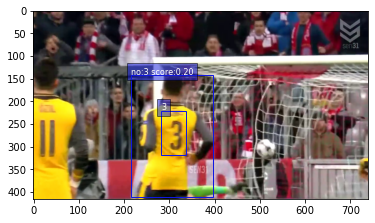

frame 1


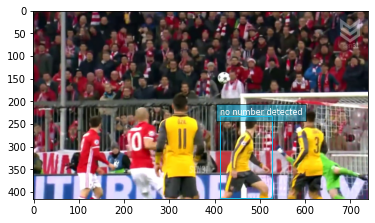

frame 2


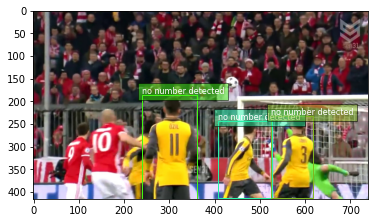

frame 3
digit 0 : 7
digit 1 : 7


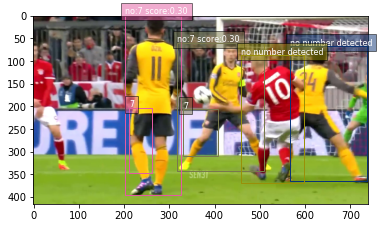

frame 4
digit 0 : 3


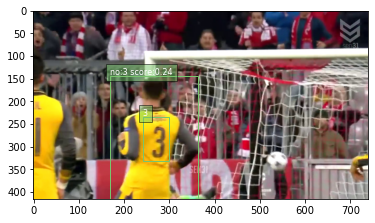

frame 5


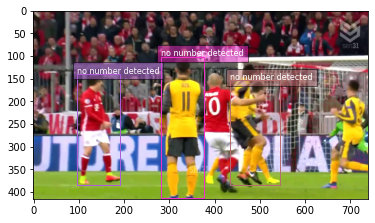

frame 6


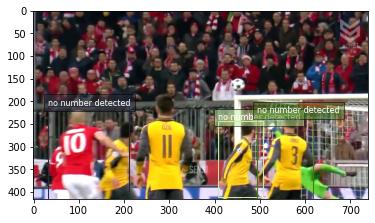

frame 7
digit 1 : 0
digit 2 : 0
digit 3 : 0


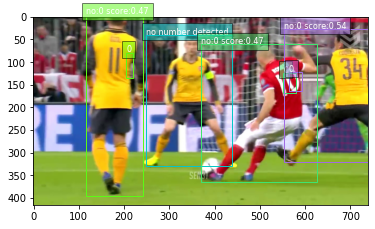

frame 8
digit 2 : 1


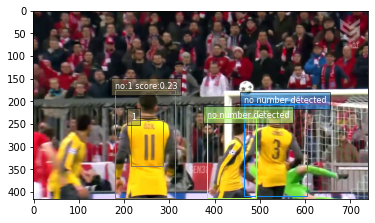

frame 9
digit 0 : 1
digit 2 : 0


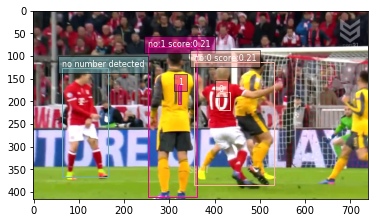

frame 10
digit 0 : 1


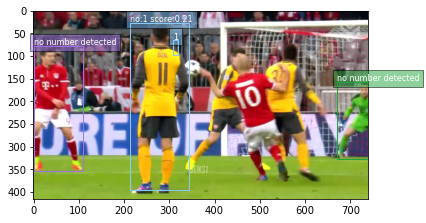

frame 11
digit 0 : 1


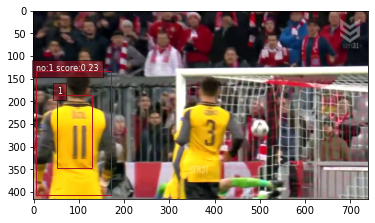

frame 12


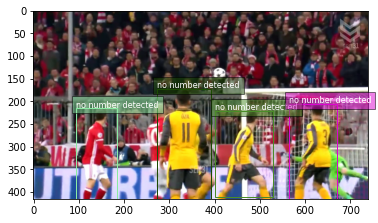

frame 13
digit 1 : 1
digit 1 : 1
digit 2 : 0


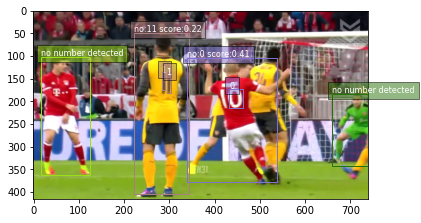

frame 14
digit 0 : 1


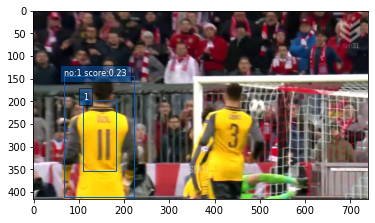

frame 15


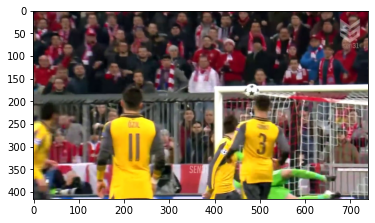

frame 16
digit 0 : 1


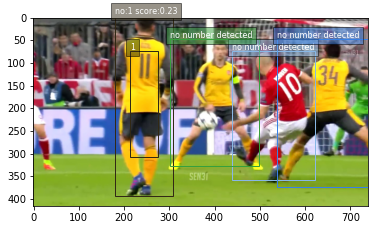

frame 17


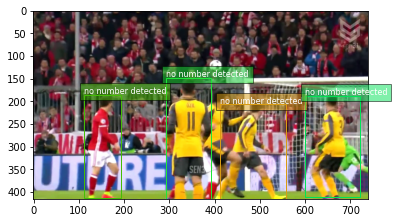

frame 18
digit 0 : 1
digit 1 : 1
digit 3 : 1


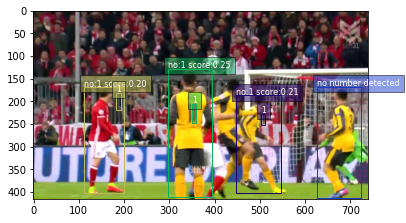

enumerate frames complete


In [14]:
import os
import glob
import json

# create folders
temp_dir, detected_frames_folder = create_folders(folder_name)

# extract frames after upload video to the frames folder
frames_folder = extract_frames(folder_name,vid, 0.1)
fnames = os.listdir(frames_folder)

# number detection set up
object_categories = ['0','1','2','3','4','5','6','7','8','9']
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.2

# looping each image through the frames folder
for i,frame in enumerate(fnames):
    # print(fnames[i])
    print("frame {}".format(i))
    
    if fnames[i].lower().endswith('.jpeg') or fnames[i].lower().endswith('.jpg'):
        
        # use player detector to detect players in the frame
        im_array =  mximg.imread(os.path.join(frames_folder, fnames[i]))
        x, orig_img = data.transforms.presets.yolo.transform_test(im_array)
        box_ids, scores, bboxes = net(x)
        
        # convert scores ranking to list
        scores_list = scores[0].astype(float).asnumpy().tolist()
        
        # lists to store detections for this frame
        frame_p_bboxes_list = []
        frame_no_list = []
        frame_no_score_list = []
        frame_n_bboxes_list = []
        
        # go through each player detected, decendingly by confidence
        for j in (scores_list):
            
            # only apply detection on scores>0.8 player
            if j[0] < 0.8:
                break
            
            # get the current player bbox
            p_index = scores_list.index(j)
            p_bbox = bboxes[0][p_index].astype(int).asnumpy()
            # print("player {}".format(p_index))
            
            frame_p_bboxes_list.append(p_bbox)
            
            # save current player's img to temp
            save_temp_crop(p_bbox, orig_img, temp_dir)
            
            with open('{}/temp.jpg'.format(temp_dir), 'rb') as image:
                f = image.read()
                b = bytearray(f)
            
            # use detetector to make prediction on temp.jpg
            final_no_detector.__setattr__(final_no_detector.content_type, 'image/jpeg')
            results = final_no_detector.predict(b,initial_args={'ContentType': 'image/jpeg'})
            detections = json.loads(results)
            
            # get detected number
            no,no_score,no_box_list = get_no_detection(temp_dir, detections['prediction'], object_categories, threshold)
            
            # save numbers' bbox info
            frame_n_bboxes_list.append(no_box_list)

            # save the no into the number list to this player
            frame_no_list.append(no)
            frame_no_score_list.append(no_score)
        
        # visualize detections
        visualize_detection("{}/{}".format(frames_folder,fnames[i]), 
                            frame_p_bboxes_list, 
                            frame_n_bboxes_list,
                            frame_no_list,  
                            frame_no_score_list,
                            detected_frames_folder,
                            i)
        
    else:
        print("not a jpeg image")
        continue
    
print("enumerate frames complete")

In [15]:
clear_folder(frames_folder)
print("clearing extracted frames")

clear_folder(detected_frames_folder)
print("clearing detected frames")

clearing extracted frames
clearing detected frames


### Delete the Endpoint

In [16]:
sagemaker.Session().delete_endpoint(final_no_detector.endpoint)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### test